In [1]:
%%html
<style>
    @import url('https://fonts.googleapis.com/css2?family=Open+Sans:wght@100..900&display=swap');
    @media print {
        @page {
            size: A3 landscape;
            margin: 0;
        }
        .jp-Cell:first-child, .jp-Cell:nth-child(2) {
            display: none;
        }
        .jp-RenderedMermaid {
            justify-content: center;
        }
        body, div#notebook, .jp-RenderedHTMLCommon {
            font-family: "Open Sans", sans-serif !important;
            font-size: 30px !important;
            font-weight: 500;
            line-height: 1.4 !important;
        }
        body, p {
            margin: 0;
        }
        blockquote {
            border: none;
            text-align: center;
            opacity: 0.5;
        }
        blockquote p {
            text-align: inherit !important;
        }
        h1 {
            margin-top: 30% !important;
            text-align: center;
        }
        h2 {
            page-break-before: always;
        }
        h1, h2, h3, h4, h5, h6, strong {
            font-weight: 800;
        }
        h1 { 
            font-size: 225% !important;
        }
        h2 {
            font-size: 180% !important;
        }
        h3 {
            font-size: 150% !important;
        }
        h4 {
            font-size: 120% !important;
        }
        h5 {
            font-size: 110% !important;
        }
        h6 {
            font-size: 100% !important;
        }
        hr {
            page-break-after: always;
            visibility: hidden;
        }
        pre {
            white-space: pre-wrap;
        }
        table, td, th, tr, tbody, thead, tfoot {
            font-size: 92% !important;
            page-break-inside: avoid !important;
        }
        .anchor-link {
            display: none;
        }
        .MJXc-display {
            display: inline !important;
            text-align: center;
        }
        :root {
            --jp-content-link-color: dodgerblue;
        }
        a code {
            color: var(--jp-content-link-color) !important;
        }
        code, pre {
            font-family: Menlo, monospace !important;
        }
        h1, h2, h3, h4, h5, h6, strong {
            font-weight: 800 !important;
        }
        .jp-RenderedHTMLCommon td,
        .jp-RenderedHTMLCommon th,
        .jp-RenderedHTMLCommon tr {
            border: 1px solid var(--md-grey-500);
        }
        .jp-CodeCell {
            margin-bottom: 1.5em;
        }
    }
</style>

In [2]:
%pip install \
    --disable-pip-version-check \
    --quiet \
    --upgrade \
    httpx \
    numpy \
    pip \
    Pillow \
    torch \
    tqdm

Note: you may need to restart the kernel to use updated packages.


# View Synthesis

> Implementing NeRF in PyTorch

## Task Description

"View synthesis" is a task which generating images of a 3D scene from a specific point of view.

<div style="text-align: center;">
    <image src="https://kaldir.vc.in.tum.de/scannetpp/static/images/nvs_task.jpg" style="width: 50vw;">
</div>

## Solution Description (Cont.)

### NeRF (Neural Radiance Field)

It can solve "View synthesis" by representing 3D scene using a neural network.

We can render the image $\hat{Y}$ from the view point $X$ by using the function $F$:

$$
\hat{Y} = F(X)
$$

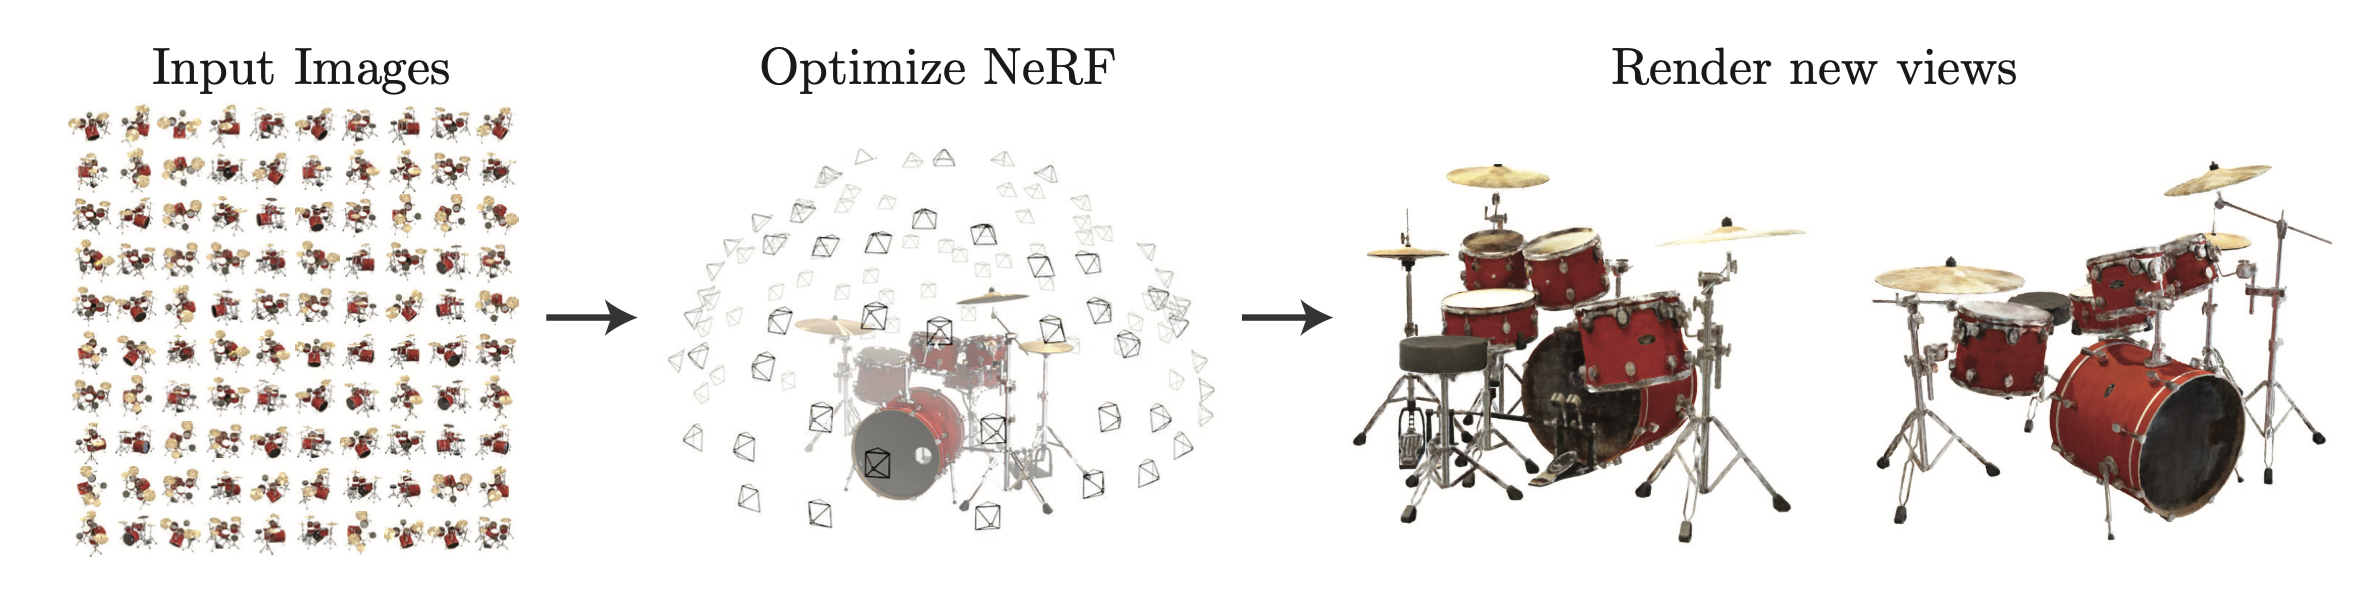

## Solution Description (Cont.)

### Volume Rendering

We render the 2D image $\hat{Y}$ with height $H$ and width $W$ from the view point $X$ using the 3D scene representation $f$:

1. The origin $o$ and the direction $d(r = 1)$ of the view point $X$ are given.
2. From the origin, we emit $H \times W$ rays through the image plane.
3. For each ray, sample $S$ positions $p(r, i)$ along the direction $d(r)$.
4. Blend the color of the positions to approximate the color of the pixel $C(r)$.
5. Gather all the colors $C(r)$ to form the image $\hat{Y}$.

$$
p(r, i) = o + t_{i} d(r), \\
c_{i}, \sigma_{i} = f(p(r, i), d(r)), \\
l(i) = \exp(-\sigma_{i} (t_{i + 1} - t_{i})), \\
\hat{C}(r) = \sum_{i = 1}^{S} c_{i} (1 - l(i)) (\prod_{j = 1}^{i - 1} l(j)), \\
\hat{Y} = \{ \hat{C}(r) | r = 1, 2, \ldots, H \times W \}
$$

## Solution Description (Cont.)

### Volume Rendering (Illustration)

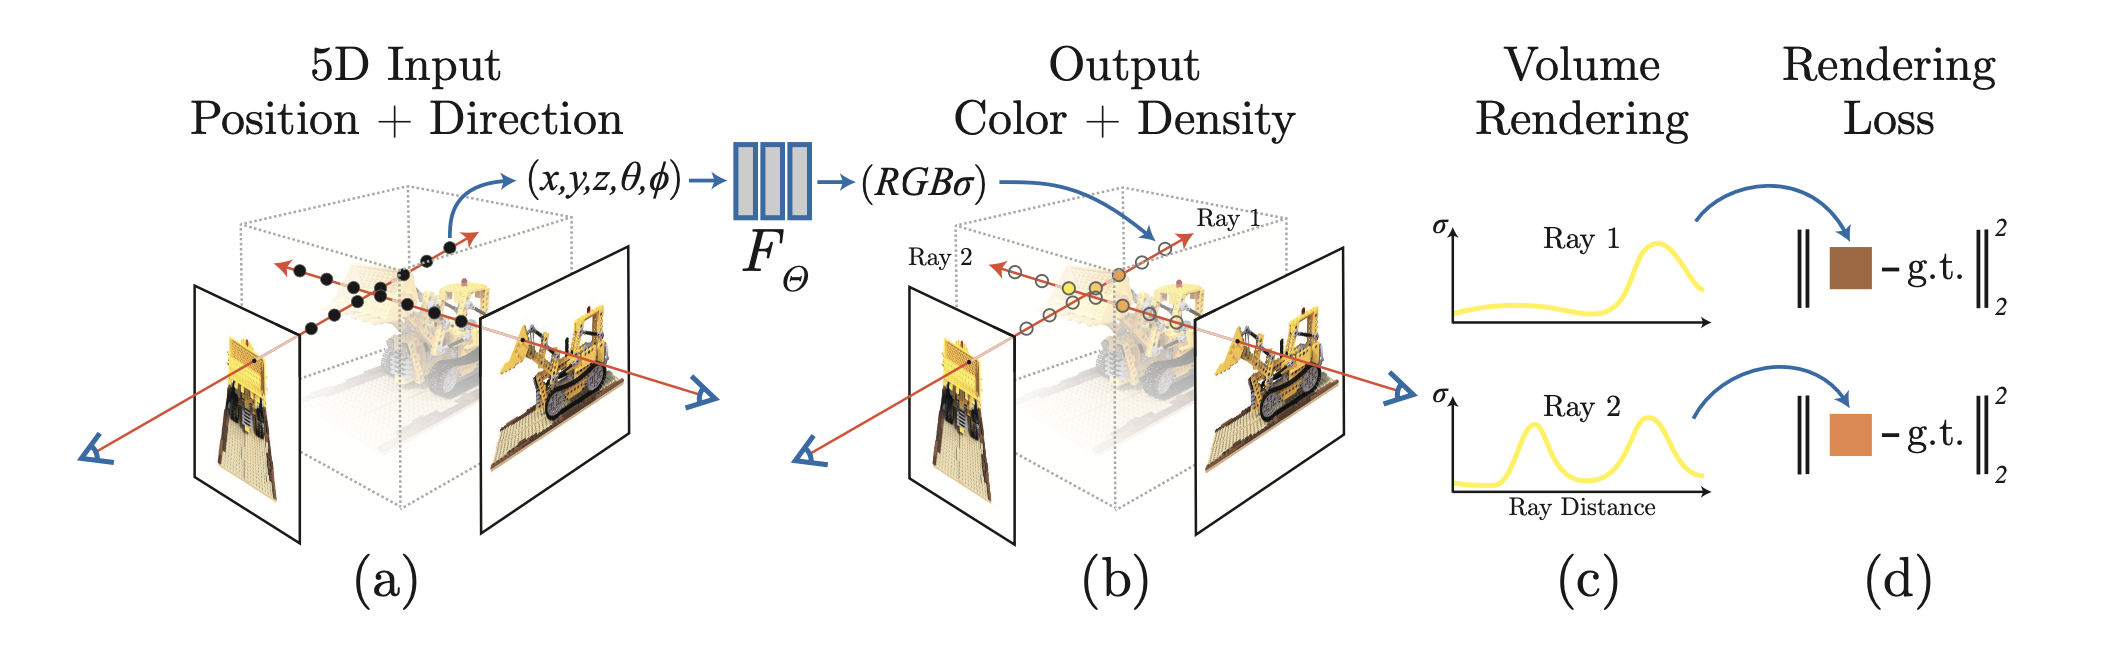

## Solution Description (Cont.)

### Volumetric Representation Estimation

To estimate the 3D scene representation $f$, we can train a fully-connected neural network.

Since the volume rendering process is differentiable, we can optimize the neural network using Gradient Descent techniques.

The loss function is defined as the Mean Squared Error between the rendered image $\hat{Y}$ and the ground truth image $Y$:

$$
\mathcal{L} = \frac{\sum_{r = 1}^{H \times W} (\hat{Y}_{r} - Y_{r})^{2}}{H \times W} \\
$$

## Solution Conclusion

NeRF is composed of three parts:

1. **$f$**: Volumetric representation estimation using a fully-connected neural network.
2. **$C$**: Volume rendering using the implicit scene representation.
3. **$\mathcal{L}$**: Loss function for training the volume rendering function $C$.

## Modules

We have implemented the following modules using PyTorch `v2.3`:
1. **Point Sampler**: To sample points from batches of rays
2. **Positional Encoder**: To apply Fourier feature encoding for the input points
3. **Volumetric Scene**: To predict the color and desity of the input points
4. **Volume Renderer**: To render the image from the sampled points and colors
5. **Trainer**: To optimize the renderer with the given images and viewpoints

## Pipeline

```mermaid
%%{init: {"theme": "neutral", "themeVariables": { "fontFamily": "Verdana", "fontSize": "22px" }}}%%
flowchart TD
    I[(Dataset)] -->|Selected Viewpoint| A[Point Sampler + Positional Encoder]
    A -->|Encoded Points| S[Volumetric Scene]
    S -->|Predicted Color| R[Volume Renderer]
    R -->|Rendered Image| T[Trainer]
    I -->|Selected Image| T
    T -.->|Loss| S
    T -.->|Loss| R
```

## Module Details

### Positional Encoder

To explore the high-frequency features in the input points, we apply Fourier feature encoding.

Each coordinate value is encoded as follows:

$$
Encode_{L}(p) \\
= \{\sin (2^0 \pi p), \cos (2^0 \pi p), \ldots, \sin (2^{L-1} \pi p), \cos (2^{L-1} \pi p)\} \\
= \{\sin (2^0 \pi p), \sin (\frac{\pi}{2} + 2^0 \pi p), \ldots, \sin (2^{L-1} \pi p), \sin (\frac{\pi}{2} + 2^{L-1} \pi p)\} \\
\text{where } p \in \mathbb{R}, \ L \in \mathbb{N}, \ Encode_{L}(p) \in \mathbb{R}^{2L}
$$

The raw and encoded coordinate values will be concatenated to form the network input.

The encoded dimensions are calculated as follows:

$$
\text{Encoded Dimension} = \text{Input Dimension} \times (2L + 1)
$$

## Module Details

### Volumetric Scene

The fully-connected neural network structure is as follows, and the skip connection is applied to 5th hidden layer:

| Constants | Description       | Value                                    |
| --------- | ----------------- | ---------------------------------------- |
| $I$       | Input Dimension   | $$3 \ (Position) + 3 \ (Direction) = 6$$ |
| $E$       | Encoded Dimension | $$I \times (2 \cdot 8 + 1) = 102$$       |
| $H$       | Hidden Dimension  | $$256$$                                  |
| $O$       | Output Dimension  | $$3 \ (Color) + 1 \ (Density) = 4$$      |

| Layer | Input Dim. | Output Dim. | Activation                      |
| ----- | ---------- | ----------- | ------------------------------- |
| 0     | $E$        | $H$         | ReLU                            |
| 1     | $H$        | $H$         | ReLU                            |
| 2     | $H$        | $H$         | ReLU                            |
| 3     | $H$        | $H$         | ReLU                            |
| 4     | $H$        | $H$         | ReLU                            |
| 5     | $H + E$    | $H$         | ReLU                            |
| 6     | $H$        | $H$         | ReLU                            |
| 7     | $H$        | $H$         | ReLU                            |
| 8     | $H$        | $O$         | Sigmoid (Color), ReLU (Density) |


## Experiment Details

### Hyper-parameters

| Constants   | Description               | Value  |
| ----------- | ------------------------- | ------ |
| $N$         | Number of Epochs          | $2000$ |
| $S$         | Sample points per ray     | $40$   |
| $B_{r}$     | Rays per batch            | $250$  |
| $L$         | Encoding Factor           | $7$    |
| $\|Test\|$  | Number of Testing Images  | $21$   |
| $\|Train\|$ | Number of Training Images | $85$   |


## References

1. View synthesis. (n.d.). In Wikipedia. Retrieved from https://en.wikipedia.org/wiki/View_synthesis
2. Neural radiance field. (n.d.). In Wikipedia. Retrieved from https://en.wikipedia.org/wiki/Neural_radiance_field
3. Mildenhall, B., Srinivasan, P. P., Tancik, M., Barron, J. T., Ramamoorthi, R., & Ng, R. (2020). NeRF: Neural radiance fields for image synthesis. arXiv preprint arXiv:2003.08934. Retrieved from https://arxiv.org/pdf/2003.08934
4. Tancik, M., Srinivasan, P. P., Mildenhall, B., Fridovich-Keil, S., Raghavan, N., Singhal, U., Ramamoorthi, R., Barron, J. T., & Ng, R. (2020). Fourier features let networks learn high frequency functions in low dimensional domains. NeurIPS. Retrieved from https://arxiv.org/pdf/2006.10739

## Module - Point Sampler

In [3]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


class PointSampler(Module):
    def __init__(
        self,
        focal: float,
        height: int,
        width: int,
        points_per_ray: int,
        device: Device,
    ):
        """
        `[4, 4] => [height, width, points_per_ray, 3 + 3 + 1]`
        """

        super(PointSampler, self).__init__()

        import torch

        focal = float(focal)
        height = int(height)
        width = int(width)
        points_per_ray = max(int(points_per_ray), 1)

        self.directions = torch.stack(
            torch.meshgrid(
                (torch.arange(float(width), device=device) - width / 2.0) / focal,
                (-torch.arange(float(height), device=device) + height / 2.0) / focal,
                torch.tensor(-1.0, device=device),
                indexing="xy",
            ),
            dim=-1,
        )
        self.points_per_ray = points_per_ray

    def forward(
        self,
        viewpoint: Tensor,
        distance_range: tuple[float, float],
        is_random: bool,
    ) -> Tensor:
        import torch

        viewpoint = torch.as_tensor(viewpoint)[:3]
        device = viewpoint.device
        distance_range = tuple(map(float, distance_range))
        is_random = bool(is_random)
        distance_max = max(distance_range)
        distance_min = min(distance_range)
        interval = (distance_max - distance_min) / self.points_per_ray

        directions = (self.directions * viewpoint[:, :3]).sum(dim=-1).unsqueeze(-2)
        origins = viewpoint[:, -1].expand_as(directions)
        distances = (
            torch.linspace(
                distance_min,
                distance_max,
                self.points_per_ray,
                device=device,
            )
            .repeat(
                (*origins.shape[:-2], 1),
            )
            .unsqueeze(-1)
        )
        if is_random:
            distances += (
                torch.rand(*origins.shape[:-2], self.points_per_ray, 1, device=device)
                * interval
            )
        positions = origins + directions * distances
        directions = directions.expand_as(positions)
        return torch.cat([positions, directions, distances], dim=-1)

## Module - Positional Encoder

In [4]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


class PositionalEncoder(Module):
    def __init__(self, encoding_factor: int, device: Device):
        """
        `[..., input_dimension] => [..., input_dimension * (2 * encoding_factor + 1)]`
        """

        import torch

        super(PositionalEncoder, self).__init__()

        encoding_factor = max(int(encoding_factor), 0)

        freq_lvls = torch.arange(encoding_factor, device=device)
        self.freq = ((2**freq_lvls) * torch.pi).repeat_interleave(2).unsqueeze_(-1)
        sine_offsets = torch.tensor([0.0, torch.pi / 2], device=device)
        self.offsets = sine_offsets.repeat(encoding_factor).unsqueeze_(-1)

    def forward(self, inputs: Tensor) -> Tensor:
        import torch

        inputs = torch.as_tensor(inputs).unsqueeze(-2)

        features = (self.freq * inputs + self.offsets).sin()
        features = torch.cat([inputs, features], dim=-2)
        features = features.reshape(*inputs.shape[:-2], -1)
        return features

    def get_last_dimension(self, input_dimension: int) -> int:
        return int(input_dimension) * (self.freq.shape[0] + 1)

## Module - Volumetric Scene

In [5]:
from torch.nn import Module


class VolumetricScene(Module):
    def __init__(self, device: Device):
        """
        `[..., 3 + 3] => [..., 4]`
        """

        super(VolumetricScene, self).__init__()

        from torch.nn import Linear, ModuleList, ReLU, Sigmoid

        ENCODING_FACTOR = 7
        self.encode = PositionalEncoder(ENCODING_FACTOR, device=device)

        I = 3 + 3
        I = self.encode.get_last_dimension(I)

        O = 4
        H = 256

        self.layers = ModuleList(
            [
                Linear(I, H, device=device),
                ReLU(),
                Linear(H, H, device=device),
                ReLU(),
                Linear(H, H, device=device),
                ReLU(),
                Linear(H, H, device=device),
                ReLU(),
                Linear(H, H, device=device),
                ReLU(),
                Linear(H + I, H, device=device),
                ReLU(),
                Linear(H, H, device=device),
                ReLU(),
                Linear(H, H, device=device),
                ReLU(),
                Linear(H, O, device=device),
            ]
        )
        self.skip_indexs = {
            10,
        }
        self.output_rgb_activation = Sigmoid()
        self.output_alpha_activation = ReLU()

    def forward(self, inputs: Tensor) -> Tensor:
        import torch

        inputs = self.encode(inputs)
        outputs = inputs

        for index, layer in enumerate(self.layers):
            if index in self.skip_indexs:
                outputs = torch.cat([outputs, inputs], dim=-1)
            outputs = layer(outputs)
        outputs = torch.cat(
            [
                self.output_rgb_activation(outputs[..., :3]),
                self.output_alpha_activation(outputs[..., 3:]),
            ],
            dim=-1,
        )
        return outputs

## Module - Volume Renderer

In [6]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


class VolumeRenderer(Module):
    def __init__(
        self,
        focal: float,
        height: int,
        width: int,
        points_per_ray: int,
        device: Device,
    ):
        """
        `[4, 4] => [height, width, 3]`
        """

        super(VolumeRenderer, self).__init__()

        self.sample = PointSampler(
            focal=focal,
            height=height,
            width=width,
            points_per_ray=points_per_ray,
            device=device,
        )
        self.predict = VolumetricScene(device=device)

    def forward(
        self,
        viewpoint: Tensor,
        rays_per_batch: int,
        distance_range: tuple[float, float],
        is_random: bool,
    ) -> Tensor:
        import torch

        rays_per_batch = max(int(rays_per_batch), 1)

        points_per_batch = rays_per_batch * self.sample.points_per_ray
        points: Tensor = self.sample(viewpoint, distance_range, is_random)
        points, distances = points[..., :-1], points[..., -1]
        colors = torch.cat(
            [
                self.predict(batch)
                for batch in TensorDataLoader(
                    data=points.reshape(-1, points.shape[-1]),
                    batch_size=points_per_batch,
                )
            ],
            dim=0,
        )
        colors = colors.reshape(*points.shape[:-1], -1)
        rgb = colors[..., :3]
        alpha = colors[..., 3]

        intervals = torch.cat(
            [
                distances[..., 1:] - distances[..., :-1],
                torch.tensor([1e9], device=distances.device).expand_as(
                    distances[..., -1:]
                ),
            ],
            dim=-1,
        )
        translucency = (-alpha * intervals).exp().unsqueeze(-1)
        transmittance = (1.0 - translucency) * torch.cumprod(translucency + 1e-9, dim=-2)
        rgb_planar = (rgb * transmittance).sum(dim=-2)

        return rgb_planar


class TensorDataLoader:
    def __init__(self, data: Tensor, batch_size: int):
        from torch import as_tensor

        self.data = as_tensor(data)
        self.batch_size = max(int(batch_size), 1)

    def __iter__(self):
        return (
            self.data[i : i + self.batch_size]
            for i in range(0, self.data.shape[0], self.batch_size)
        )

    def __len__(self):
        return -(-len(self.data) // self.batch_size)

## Module - Trainer

In [7]:
from dataclasses import dataclass
from torch import Tensor
from torch.types import Device


@dataclass
class Trainer:
    test_dataset: "ViewSynthesisDataset"
    train_dataset: "ViewSynthesisDataset"

    @staticmethod
    def from_dataset(
        dataset: "ViewSynthesisDataset",
        train_ratio: float,
        device: Device,
    ):
        train_data_count = max(int(round(dataset.count * train_ratio)), 1)
        test_data_count = dataset.count - train_data_count
        data_split_index = -test_data_count
        focal = dataset.focal
        height = dataset.height
        images = dataset.images
        viewpoints = dataset.viewpoints
        width = dataset.width

        return Trainer(
            test_dataset=ViewSynthesisDataset(
                count=test_data_count,
                focal=focal,
                height=height,
                images=images[data_split_index:],
                viewpoints=viewpoints[data_split_index:],
                width=width,
            ).set_device(device),
            train_dataset=ViewSynthesisDataset(
                count=train_data_count,
                focal=focal,
                height=height,
                images=images[:data_split_index],
                viewpoints=viewpoints[:data_split_index],
                width=width,
            ).set_device(device),
        )

    def train(
        self,
        render: VolumeRenderer,
        epochs: int,
        rays_per_batch: int,
        distance_range: tuple[float, float],
        show_progress: bool,
    ) -> None:
        import torch
        from torch.nn import MSELoss
        from torch.optim import Adam
        from tqdm import tqdm

        EPOCHS_PER_DEMO = 250

        criterion = MSELoss()
        optimizer = Adam(render.parameters(), lr=5e-4)
        progress = tqdm(
            disable=not show_progress,
            desc=f"Fitting the renderer to {self.train_dataset.count}x images and viewpoints",
            colour="green",
            dynamic_ncols=True,
            total=epochs,
        )

        with progress:
            for epoch in range(epochs):
                true_image, viewpoint = self.train_dataset.get_image_and_viewpoint()
                optimizer.zero_grad()
                rendered_image: Tensor = render(
                    viewpoint=viewpoint,
                    rays_per_batch=rays_per_batch,
                    distance_range=distance_range,
                    is_random=True,
                )
                loss = criterion(rendered_image, true_image)
                loss.backward()
                optimizer.step()

                if show_progress and epoch % EPOCHS_PER_DEMO == 0:
                    with torch.no_grad():
                        true_image_demo, viewpoint_demo = (
                            self.train_dataset.get_image_and_viewpoint(0)
                        )
                        rendered_image_demo = render(
                            viewpoint=viewpoint_demo,
                            rays_per_batch=rays_per_batch,
                            distance_range=distance_range,
                            is_random=False,
                        )
                        Trainer.display(
                            torch.cat([true_image_demo, rendered_image_demo], dim=1)
                        )

                progress.update()

    def test(
        self,
        render: VolumeRenderer,
        rays_per_batch: int,
        distance_range: tuple[float, float],
    ) -> None:
        from math import log10
        import torch
        from torch.nn.functional import mse_loss

        with torch.no_grad():
            for index in range(self.test_dataset.count):
                true_image, viewpoint = self.test_dataset.get_image_and_viewpoint(index)
                rendered_image = render(
                    viewpoint=viewpoint,
                    rays_per_batch=rays_per_batch,
                    distance_range=distance_range,
                    is_random=False,
                )
                quality_mse = mse_loss(rendered_image, true_image).item()
                quality_psnr = -10 * log10(quality_mse)
                display(
                    dict(
                        test_index=index,
                        quality=dict(mse=quality_mse, psnr=quality_psnr),
                    )
                )

                Trainer.display(torch.cat([true_image, rendered_image], dim=1))

    @staticmethod
    def display(image: Tensor):
        from IPython.display import display
        from PIL import Image
        from torch import uint8

        return display(
            Image.fromarray((image * 255).round().type(uint8).numpy(force=True))
        )


@dataclass
class ViewSynthesisDataset:
    count: int
    focal: float
    height: int
    images: Tensor
    viewpoints: Tensor
    width: int

    def __post_init__(self) -> None:
        if self.images.shape[0] != self.viewpoints.shape[0]:
            raise ValueError("The number of images and viewpoints must be the same")

    @staticmethod
    def from_numpy(url: str) -> "ViewSynthesisDataset":
        from httpx import get
        from io import BytesIO
        from numpy import load

        import torch

        try:
            file = BytesIO(
                get(url, follow_redirects=True, timeout=60).raise_for_status().content
            )
        except:
            file = open(url, "rb")

        with file as file_entered:
            arrays = load(file_entered)
            focal = float(arrays["focal"])
            images = torch.as_tensor(arrays["images"])
            viewpoints = torch.as_tensor(arrays["poses"])

        return ViewSynthesisDataset(
            count=images.shape[0],
            focal=focal,
            height=images.shape[1],
            images=images,
            viewpoints=viewpoints,
            width=images.shape[2],
        )

    def get_image_and_viewpoint(self, index: int | None = None) -> tuple[Tensor, Tensor]:
        from random import randint

        if index is not None:
            index = int(index)
        else:
            index = randint(0, self.count - 1)

        return self.images[index], self.viewpoints[index]

    def set_device(self, device: Device) -> "ViewSynthesisDataset":
        self.images = self.images.to(device)
        self.viewpoints = self.viewpoints.to(device)
        return self

    def __repr__(self) -> str:
        repr = f"{self.__class__.__name__}("
        for name, value in self.__dict__.items():
            if isinstance(value, Tensor):
                value = f"Tensor(shape={tuple(value.shape)}, dtype={value.dtype})"
            elif type(value) is float:
                value = f"{value:.7f}"
            repr += f"\n  {name}={value},"
        repr += "\n)"
        return repr

## Experiment

In [8]:
def main() -> None:
    import torch

    EPOCHS = 2000
    RAYS_PER_BATCH = 250
    POINTS_PER_RAY = 40
    DISTANCE_RANGE = (2.0, 6.0)

    # The original dataset is retrieved from
    # http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
    dataset = ViewSynthesisDataset.from_numpy(
        "https://raw.githubusercontent.com/AsherJingkongChen/nerf/main/tiny_nerf_data.npz"
    )
    device = (
        "cuda"
        if torch.cuda.is_available()
        else ("mps" if torch.backends.mps.is_available() else "cpu")
    )
    render = VolumeRenderer(
        focal=dataset.focal,
        height=dataset.height,
        width=dataset.width,
        points_per_ray=POINTS_PER_RAY,
        device=device,
    )
    trainer = Trainer.from_dataset(dataset=dataset, train_ratio=0.8, device=device)

    display(dict(trainer=trainer, render=render))

    trainer.train(
        render=render,
        epochs=EPOCHS,
        rays_per_batch=RAYS_PER_BATCH,
        distance_range=DISTANCE_RANGE,
        show_progress=True,
    )
    trainer.test(
        render=render,
        rays_per_batch=RAYS_PER_BATCH,
        distance_range=DISTANCE_RANGE,
    )
    torch.save(render.state_dict(), "VolumeRenderer.pth")

{'trainer': Trainer(test_dataset=ViewSynthesisDataset(
   count=21,
   focal=138.8888789,
   height=100,
   images=Tensor(shape=(21, 100, 100, 3), dtype=torch.float32),
   viewpoints=Tensor(shape=(21, 4, 4), dtype=torch.float32),
   width=100,
 ), train_dataset=ViewSynthesisDataset(
   count=85,
   focal=138.8888789,
   height=100,
   images=Tensor(shape=(85, 100, 100, 3), dtype=torch.float32),
   viewpoints=Tensor(shape=(85, 4, 4), dtype=torch.float32),
   width=100,
 )),
 'render': VolumeRenderer(
   (sample): PointSampler()
   (predict): VolumetricScene(
     (encode): PositionalEncoder()
     (layers): ModuleList(
       (0): Linear(in_features=90, out_features=256, bias=True)
       (1): ReLU()
       (2): Linear(in_features=256, out_features=256, bias=True)
       (3): ReLU()
       (4): Linear(in_features=256, out_features=256, bias=True)
       (5): ReLU()
       (6): Linear(in_features=256, out_features=256, bias=True)
       (7): ReLU()
       (8): Linear(in_features=256, out

Fitting the renderer to 85x images and viewpoints:   0%|          | 0/2000 [00:00<?, ?it/s]

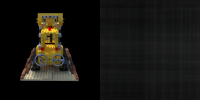

Fitting the renderer to 85x images and viewpoints:  12%|█▎        | 250/2000 [02:00<13:54,  2.10it/s]

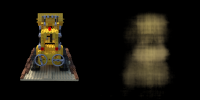

Fitting the renderer to 85x images and viewpoints:  25%|██▌       | 500/2000 [03:59<11:55,  2.10it/s]

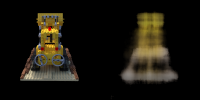

Fitting the renderer to 85x images and viewpoints:  38%|███▊      | 750/2000 [05:59<09:57,  2.09it/s]

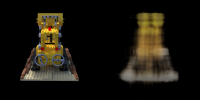

Fitting the renderer to 85x images and viewpoints:  50%|█████     | 1000/2000 [07:58<07:54,  2.11it/s]

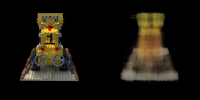

Fitting the renderer to 85x images and viewpoints:  62%|██████▎   | 1250/2000 [09:57<05:55,  2.11it/s]

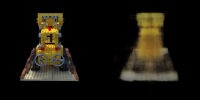

Fitting the renderer to 85x images and viewpoints:  75%|███████▌  | 1500/2000 [11:57<03:57,  2.11it/s]

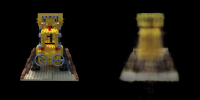

Fitting the renderer to 85x images and viewpoints:  88%|████████▊ | 1750/2000 [13:56<01:59,  2.09it/s]

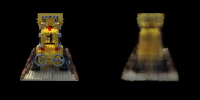

Fitting the renderer to 85x images and viewpoints: 100%|██████████| 2000/2000 [15:55<00:00,  2.09it/s]


{'test_index': 0,
 'quality': {'mse': 0.00431809900328517, 'psnr': 23.647074045938368}}

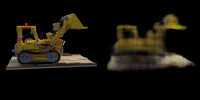

{'test_index': 1,
 'quality': {'mse': 0.012723319232463837, 'psnr': 18.95399576085723}}

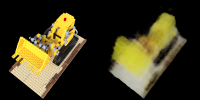

{'test_index': 2,
 'quality': {'mse': 0.011627595871686935, 'psnr': 19.34510070963042}}

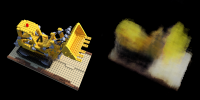

{'test_index': 3,
 'quality': {'mse': 0.008757594972848892, 'psnr': 20.57615144223167}}

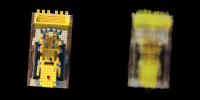

{'test_index': 4,
 'quality': {'mse': 0.00900075864046812, 'psnr': 20.45720883951384}}

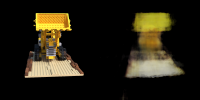

{'test_index': 5,
 'quality': {'mse': 0.008951352909207344, 'psnr': 20.48111320371352}}

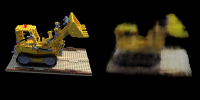

{'test_index': 6,
 'quality': {'mse': 0.010090090334415436, 'psnr': 19.961049456003014}}

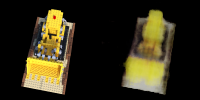

{'test_index': 7,
 'quality': {'mse': 0.011789647862315178, 'psnr': 19.284991663838994}}

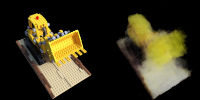

{'test_index': 8,
 'quality': {'mse': 0.010006370954215527, 'psnr': 19.997234010745757}}

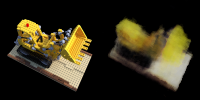

{'test_index': 9,
 'quality': {'mse': 0.006928077433258295, 'psnr': 21.593872669709548}}

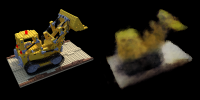

{'test_index': 10,
 'quality': {'mse': 0.019014297053217888, 'psnr': 17.209197255535603}}

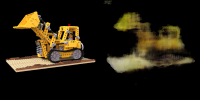

{'test_index': 11,
 'quality': {'mse': 0.006408484652638435, 'psnr': 21.932446514170643}}

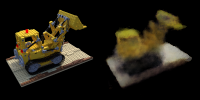

{'test_index': 12,
 'quality': {'mse': 0.006725886836647987, 'psnr': 21.72250443984329}}

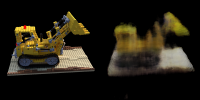

{'test_index': 13,
 'quality': {'mse': 0.00920819491147995, 'psnr': 20.358254964933487}}

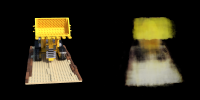

{'test_index': 14,
 'quality': {'mse': 0.01419169083237648, 'psnr': 18.47965858564731}}

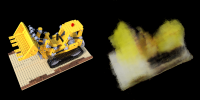

{'test_index': 15,
 'quality': {'mse': 0.009500782936811447, 'psnr': 20.222406040662918}}

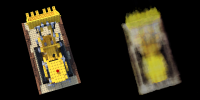

{'test_index': 16,
 'quality': {'mse': 0.01330608781427145, 'psnr': 18.759496147297654}}

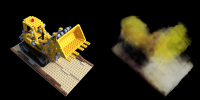

{'test_index': 17,
 'quality': {'mse': 0.0062311915680766106, 'psnr': 22.05428896846717}}

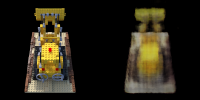

{'test_index': 18,
 'quality': {'mse': 0.009252408519387245, 'psnr': 20.337452001773766}}

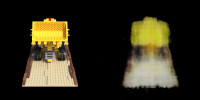

{'test_index': 19,
 'quality': {'mse': 0.0032106211874634027, 'psnr': 24.9341093264569}}

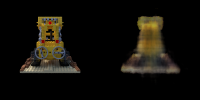

{'test_index': 20,
 'quality': {'mse': 0.008966628462076187, 'psnr': 20.47370825134895}}

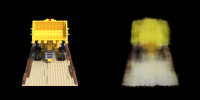

In [9]:
if __name__ == "__main__":
    main()